# Cleaning `customer_funding_source` data

We have ways for cleaning `micropayments` and `device_transactions`. Based on information we've recently received from Littlepay, we may be able to clean `customer_funding_sources` as well.

A few things to note:
* Each `customer_funding_source` file is a full extract of the `customer_funding_source`,  not an increment, so there is duplication across files.
* `customer_id`s may become inactive and be replaced. In these cases, both `customer_id` values will be present in the data export, but the active one will be set in the `principal_customer_id`.

Maybe the best approach is to use the most recent file only and match with other tables on either the `principal_customer_id` or `funding_source_vault_id`.

In [2]:
from calitp import get_engine, query_sql, magics
# import pandas as pd
# import pyarrow

In [3]:
import os
os.environ['AIRFLOW_ENV'] = 'development'

Based on the information from Littlepay, to get the latest state of `customer_funding_sources` information, we should just need to keep the latest file.

In [3]:
%%sql

select max(_FILE_NAME) as fn
from payments.customer_funding_source

,fn
0,gs://gtfs-data-test/payments-processed/custome...


Except it's not just the one latest file we need, but the latest file from each synced batch of data. For example, `mst` and `sbmtd` each have their own batches of data, while `sacrt` and `clean-air-express` are grouped together under the `cal-itp` batch. Normally we would use the `participant_id` for this, but `customer_funding_sources` does not have a `participant_id`. But fret not, we can extract this information from the synced files' names. We've included views in our pipeline that add the source file name, as well as the account and exported datetime as parsed from the filename, to each record.

In [4]:
%%sql

select distinct 
    calitp_export_account,
    calitp_export_datetime,
    calitp_file_name
from payments.stg_enriched_customer_funding_source

,calitp_export_account,calitp_export_datetime,calitp_file_name
0,cal-itp,2021-09-20 08:23:00,gs://gtfs-data-test/payments-processed/custome...
1,cal-itp,2021-10-15 08:05:00,gs://gtfs-data-test/payments-processed/custome...
2,cal-itp,2021-09-17 04:56:00,gs://gtfs-data-test/payments-processed/custome...
3,cal-itp,2021-10-02 05:03:00,gs://gtfs-data-test/payments-processed/custome...
4,cal-itp,2021-09-20 07:56:00,gs://gtfs-data-test/payments-processed/custome...
...,...,...,...
300,mst,2021-08-25 05:45:00,gs://gtfs-data-test/payments-processed/custome...
301,mst,2021-08-13 05:36:00,gs://gtfs-data-test/payments-processed/custome...
302,mst,2021-08-14 05:31:00,gs://gtfs-data-test/payments-processed/custome...
303,mst,2021-08-16 05:38:00,gs://gtfs-data-test/payments-processed/custome...


Using this, we can get the latest export metadata for each account.

In [5]:
%%sql

create or replace table sandbox.latest_export_metadata
options(
  expiration_timestamp=timestamp_add(current_timestamp(), interval 3 hour)
) as (
    with
    
    latest_export_times as (
        select calitp_export_account,
               max(calitp_export_datetime) as calitp_export_datetime
        from payments.stg_enriched_customer_funding_source
        group by 1
    )
    
    select distinct
        calitp_export_account,
        calitp_export_datetime,
        calitp_file_name
    from payments.stg_enriched_customer_funding_source
    join latest_export_times using (calitp_export_account, calitp_export_datetime)
)

,calitp_export_account,calitp_export_datetime,calitp_file_name
0,mst,2021-11-18 05:01:00,gs://gtfs-data-test/payments-processed/custome...
1,cal-itp,2021-11-18 05:02:00,gs://gtfs-data-test/payments-processed/custome...
2,sbmtd,2021-11-18 05:07:00,gs://gtfs-data-test/payments-processed/custome...


This gives us the latest date of export for each AWS account that we're pulling LittlePay data from. As a sanity check, I'd like to see whether all IDs are represented in the extracts with these dates. If we truly have full exports each time, then every ID should be represented in each file. Now, there are three ID fields in the table and I'm not sure which is ; I'm wondering whether any of them is more likely to be unique. Maybe if one has significantly more unique values than the others...

In [6]:
%%sql

select
    count(distinct funding_source_id) as cnt_funding_source_id,
    count(distinct funding_source_vault_id) as cnt_funding_source_vault_id,
    count(distinct customer_id) as cnt_customer_id
from payments.stg_enriched_customer_funding_source

,cnt_funding_source_id,cnt_funding_source_vault_id,cnt_customer_id
0,4912,4556,4556


So, there's no clear unique-looking field here. In fact, I wonder whether the vault ID and the customer ID are 1-to-1. Let's check the number of unique paired (`funding_source_vault_id`,`customer_id`)...

In [7]:
%%sql

select count(*) from (
    select distinct funding_source_vault_id, customer_id
    from payments.stg_enriched_customer_funding_source
) q

,f0_
0,4791


We end up with a different count. So, even though there are the same number of uniques across those two IDs, they're not quite 1:1.

Next, let's see how many `funding_source_id` values there are across the data set that don't exist in the latest export files.

In [8]:
%%sql

with

latest_funding_sources as (
    select distinct funding_source_id
    from payments.stg_enriched_customer_funding_source
    join sandbox.latest_export_metadata using (calitp_export_account, calitp_export_datetime)
)

select
    calitp_export_account,
    calitp_export_datetime,
    count(*)
from payments.stg_enriched_customer_funding_source
where funding_source_id not in (select funding_source_id from latest_funding_sources)
group by 1, 2
order by 2 desc, 1

,calitp_export_account,calitp_export_datetime,f0_
0,sbmtd,2021-11-17 05:24:00,15
1,cal-itp,2021-11-17 05:20:00,4
2,mst,2021-11-17 05:18:00,18
3,sbmtd,2021-11-16 05:12:00,5
4,cal-itp,2021-11-16 05:07:00,10
...,...,...,...
297,mst,2021-06-21 05:16:00,9
298,mst,2021-06-20 05:29:00,19
299,mst,2021-06-19 06:30:00,23
300,mst,2021-06-18 05:29:00,20


What this tells me is that there are a bunch of funding source IDs that were in past files are are not in the latest file. _Quel dommage_. My first thought is that maybe we should filter for the latest file available record for each id -- essentially keep the latest version of each.

Below I do the same check for `customer_id` and `funding_source_vault_id`.

In [9]:
%%sql

with

latest_funding_source_vaults as (
    select distinct funding_source_vault_id
    from payments.stg_enriched_customer_funding_source
    join sandbox.latest_export_metadata using (calitp_export_account, calitp_export_datetime)
)

select
    calitp_export_account,
    calitp_export_datetime,
    count(*)
from payments.stg_enriched_customer_funding_source
where funding_source_vault_id not in (select * from latest_funding_source_vaults)
group by 1, 2
order by 2 desc, 1

,calitp_export_account,calitp_export_datetime,f0_
0,sbmtd,2021-11-17 05:24:00,15
1,cal-itp,2021-11-17 05:20:00,4
2,mst,2021-11-17 05:18:00,18
3,sbmtd,2021-11-16 05:12:00,5
4,cal-itp,2021-11-16 05:07:00,10
...,...,...,...
297,mst,2021-06-21 05:16:00,9
298,mst,2021-06-20 05:29:00,19
299,mst,2021-06-19 06:30:00,23
300,mst,2021-06-18 05:29:00,20


In [10]:
%%sql

with

latest_customers as (
    select distinct customer_id
    from payments.stg_enriched_customer_funding_source
    join sandbox.latest_export_metadata using (calitp_export_account, calitp_export_datetime)
)

select
    calitp_export_account,
    calitp_export_datetime,
    count(*)
from payments.stg_enriched_customer_funding_source
where customer_id not in (select * from latest_customers)
group by 1, 2
order by 2 desc, 1

,calitp_export_account,calitp_export_datetime,f0_
0,sbmtd,2021-11-17 05:24:00,15
1,cal-itp,2021-11-17 05:20:00,4
2,mst,2021-11-17 05:18:00,17
3,sbmtd,2021-11-16 05:12:00,5
4,cal-itp,2021-11-16 05:07:00,10
...,...,...,...
297,mst,2021-06-21 05:16:00,9
298,mst,2021-06-20 05:29:00,19
299,mst,2021-06-19 06:30:00,23
300,mst,2021-06-18 05:29:00,20


Just spot checking, it looks like all three IDs have around the same numbers of values that are missing from the latest files. Now I want to know whether there are any gaps for any IDs. In other words, is an ID in an exported file one day, gone the next, and back on the third day? Ideally, if IDs can disappear, they'll stay gone.

To check this, I'll match each sighting of an ID in one file with the next file the ID was seen in. Since the exports aren't always on consecutive days, I'll create a separate field for the export rank of the export files.

In [11]:
%%sql

create or replace table sandbox.ranked_customer_funding_source_exports
options(
  expiration_timestamp=timestamp_add(current_timestamp(), interval 3 hour)
) as (
    with

    customer_funding_source_exports as (
        select distinct
            calitp_export_account,
            calitp_export_datetime
        from payments.stg_enriched_customer_funding_source
    )

    select
        calitp_export_account,
        calitp_export_datetime,
        rank() over (partition by calitp_export_account order by calitp_export_datetime desc) as calitp_export_rank
    from customer_funding_source_exports
    order by 3, 2, 1
)

,calitp_export_account,calitp_export_datetime,calitp_export_rank
0,mst,2021-11-18 05:01:00,1
1,cal-itp,2021-11-18 05:02:00,1
2,sbmtd,2021-11-18 05:07:00,1
3,mst,2021-11-17 05:18:00,2
4,cal-itp,2021-11-17 05:20:00,2
...,...,...,...
300,mst,2021-06-21 05:16:00,155
301,mst,2021-06-20 05:29:00,156
302,mst,2021-06-19 06:30:00,157
303,mst,2021-06-18 05:29:00,158


Starting with the `funding_source_vault_id` field, we can now check for gaps...

In [12]:
%%sql

with

unique_ids as (
    select distinct
        calitp_export_account,
        calitp_export_datetime,
        funding_source_vault_id as the_id
    from payments.stg_enriched_customer_funding_source
),

gap_finder as (
    select
        calitp_export_account,
        the_id,
        calitp_export_datetime dt1,
        calitp_export_rank as rank1,
        lag(calitp_export_datetime) over (partition by calitp_export_account, the_id order by calitp_export_datetime) as dt2,
        lag(calitp_export_rank) over (partition by calitp_export_account, the_id order by calitp_export_datetime) as rank2
    from unique_ids
    join sandbox.ranked_customer_funding_source_exports using (calitp_export_account, calitp_export_datetime)
)

select * from gap_finder
where rank2 is not null
and rank2 - rank1 > 1

,calitp_export_account,the_id,dt1,rank1,dt2,rank2
0,cal-itp,3b2eba4d-8c86-41cb-b52f-44b626e63921,2021-10-15 08:05:00,35,2021-10-07 05:26:00,44
1,cal-itp,3cbc52a7-5bfe-4b3a-9c63-c6090547655a,2021-10-15 08:05:00,35,2021-09-29 04:42:00,52
2,cal-itp,41ea2ff0-a688-4898-b4a5-f4fed5c873cc,2021-10-15 08:05:00,35,2021-10-13 04:40:00,38
3,cal-itp,6782b117-7a31-4aa3-9fa4-c4c4534719c0,2021-10-02 05:03:00,49,2021-09-22 04:54:00,59
4,cal-itp,6782b117-7a31-4aa3-9fa4-c4c4534719c0,2021-10-15 08:05:00,35,2021-10-02 05:03:00,49
...,...,...,...,...,...,...
12549,sbmtd,5cd00610-139d-42d6-81f6-488c0a33dd68,2021-10-15 08:06:00,36,2021-09-21 04:59:00,61
12550,sbmtd,a72d38a9-4c51-4e0a-8d07-13575807e79b,2021-10-15 08:06:00,36,2021-09-21 04:59:00,61
12551,sbmtd,c97abe98-ad87-4772-b380-0ba982de8cd9,2021-10-15 08:06:00,36,2021-09-21 04:59:00,61
12552,sbmtd,d33a4447-3c09-4230-91a2-d0594e06b29b,2021-10-15 08:06:00,36,2021-09-21 04:59:00,61


Same as above, except `funding_source_id`...

In [13]:
%%sql

with

unique_ids as (
    select distinct
        calitp_export_account,
        calitp_export_datetime,
        funding_source_id as the_id
    from payments.stg_enriched_customer_funding_source
),

gap_finder as (
    select
        calitp_export_account,
        the_id,
        calitp_export_datetime dt1,
        calitp_export_rank as rank1,
        lag(calitp_export_datetime) over (partition by calitp_export_account, the_id order by calitp_export_datetime) as dt2,
        lag(calitp_export_rank) over (partition by calitp_export_account, the_id order by calitp_export_datetime) as rank2
    from unique_ids
    join sandbox.ranked_customer_funding_source_exports using (calitp_export_account, calitp_export_datetime)
)

select * from gap_finder
where rank2 is not null
and rank2 - rank1 > 1

,calitp_export_account,the_id,dt1,rank1,dt2,rank2
0,cal-itp,04046f1d-c9c5-4669-91d7-b11e3e7f2770,2021-10-02 05:03:00,49,2021-09-28 04:36:00,53
1,cal-itp,04046f1d-c9c5-4669-91d7-b11e3e7f2770,2021-10-15 08:05:00,35,2021-10-02 05:03:00,49
2,cal-itp,8d002053-805d-4488-bab5-82accba73408,2021-10-15 08:05:00,35,2021-10-02 05:03:00,49
3,cal-itp,a299397b-9a42-4873-81f4-6885613f8c2f,2021-10-15 08:05:00,35,2021-09-30 04:38:00,51
4,cal-itp,a5d3c5d5-fdce-4602-a2fd-95fb55ec8e0f,2021-09-18 05:00:00,65,2021-09-15 04:52:00,68
...,...,...,...,...,...,...
13088,sbmtd,76e2f5fc-093b-417a-ba22-e0920fd04543,2021-10-15 08:06:00,36,2021-09-21 04:59:00,61
13089,sbmtd,156ff5a5-d354-420f-902b-e362a7e0049b,2021-10-15 08:06:00,36,2021-09-21 04:59:00,61
13090,sbmtd,f673a1e5-a6d5-4e22-aa53-4a7f5e50d199,2021-10-15 08:06:00,36,2021-09-21 04:59:00,61
13091,sbmtd,030fdde5-f9b9-45e2-959f-3177078a3b4c,2021-10-15 08:06:00,36,2021-09-21 04:59:00,61


And, finally, `customer_id`...

In [14]:
%%sql

with

unique_ids as (
    select distinct
        calitp_export_account,
        calitp_export_datetime,
        customer_id as the_id
    from payments.stg_enriched_customer_funding_source
),

gap_finder as (
    select
        calitp_export_account,
        the_id,
        calitp_export_datetime dt1,
        calitp_export_rank as rank1,
        lag(calitp_export_datetime) over (partition by calitp_export_account, the_id order by calitp_export_datetime) as dt2,
        lag(calitp_export_rank) over (partition by calitp_export_account, the_id order by calitp_export_datetime) as rank2
    from unique_ids
    join sandbox.ranked_customer_funding_source_exports using (calitp_export_account, calitp_export_datetime)
)

select * from gap_finder
where rank2 is not null
and rank2 - rank1 > 1

,calitp_export_account,the_id,dt1,rank1,dt2,rank2
0,cal-itp,0dacdc3b-abce-4d86-bf4d-b5a37db46ade,2021-10-15 08:05:00,35,2021-10-06 06:32:00,45
1,cal-itp,b4f12f92-08f6-4ee8-bc88-860c9c96b945,2021-09-18 05:00:00,65,2021-09-08 04:47:00,74
2,cal-itp,ce4b74d1-2581-4463-90a6-20a9115cc4e7,2021-09-18 05:00:00,65,2021-09-09 04:50:00,73
3,mst,1a08d9e1-62ba-4382-91b0-76bd2a200e22,2021-10-15 08:05:00,35,2021-10-03 04:36:00,48
4,mst,3b4bba20-01ef-4190-bdd1-e00140c177b2,2021-10-15 08:05:00,35,2021-10-04 04:37:00,47
...,...,...,...,...,...,...
12649,sbmtd,b1fee996-f016-45c9-b742-5beb8b31df50,2021-10-15 08:06:00,36,2021-09-21 04:59:00,61
12650,sbmtd,e483c6c2-6ca3-4b41-b07f-aa25aba79002,2021-10-15 08:06:00,36,2021-09-21 04:59:00,61
12651,sbmtd,12ac26c3-b927-4308-b740-042a2fc56e72,2021-10-15 08:06:00,36,2021-09-21 04:59:00,61
12652,sbmtd,e0c2e2cf-ca48-4c48-a715-6bcf706ee77c,2021-10-15 08:06:00,36,2021-09-21 04:59:00,61


So, there are a lot of gaps. And looking at the number of rows in each export file, maybe what we have here is a combination of snapshot and incremental processes.

**In that case, we could maybe just use the latest export on a per-record basis. There's still a question of which ID field(s) we should use as the unique identifier.**

In [4]:
%%sql -o num_records_per_export

select
    calitp_export_account,
    calitp_export_datetime,
    count(*) as num_records
from payments.stg_enriched_customer_funding_source
group by 1, 2
order by 1, 2

,calitp_export_account,calitp_export_datetime,num_records
0,cal-itp,2021-09-03 04:46:00,17
1,cal-itp,2021-09-04 04:52:00,14
2,cal-itp,2021-09-05 04:47:00,8
3,cal-itp,2021-09-06 04:45:00,5
4,cal-itp,2021-09-08 04:47:00,5
...,...,...,...
300,sbmtd,2021-11-14 05:15:00,9
301,sbmtd,2021-11-15 05:03:00,6
302,sbmtd,2021-11-16 05:12:00,5
303,sbmtd,2021-11-17 05:24:00,15


AttributeError: 'Line2D' object has no property 'sublots'

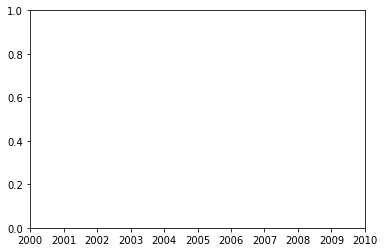

In [30]:
# num_records_per_export.plot(x='calitp_export_datetime', y='num_records')

df = num_records_per_export.set_index('calitp_export_datetime')
df_mst = df[df.calitp_export_account == 'mst'][['num_records']]
df_sbmtd = df[df.calitp_export_account == 'sbmtd'][['num_records']]
df_calitp = df[df.calitp_export_account == 'cal-itp'][['num_records']]

import pandas as pd
pd.concat([df_mst, df_sbmtd, df_calitp], join='outer', axis=1).plot(sublots=True)

## Associating by `customer_id`

Based on response from Littlepay, it seems we should assume that all customer IDs attached to the same transactions/micropayments are the same person.

In [77]:
%%sql -o joined_customer_ids

with

first_taps as (
    select *
    from payments.stg_cleaned_device_transactions
    join payments.stg_cleaned_device_transaction_types using (littlepay_transaction_id)
    join payments.stg_cleaned_micropayment_device_transactions using (littlepay_transaction_id)
    where transaction_type in ('single', 'on')
),

second_taps as (
    select *
    from payments.stg_cleaned_device_transactions
    join payments.stg_cleaned_device_transaction_types using (littlepay_transaction_id)
    join payments.stg_cleaned_micropayment_device_transactions using (littlepay_transaction_id)
    where transaction_type in ('off')
)

select
    m.funding_source_vault_id,
    m.customer_id as m_customer_id,
    cast(m.transaction_time as timestamp) as m_transaction_time,
    t1.customer_id as t1_customer_id,
    t2.customer_id as t2_customer_id,
    cast(t1.transaction_date_time_utc as timestamp) as t1_transaction_date_time_utc,
    cast(t2.transaction_date_time_utc as timestamp) as t2_transaction_date_time_utc,
from payments.stg_cleaned_micropayments as m
join first_taps  as t1 using (micropayment_id)
left join second_taps as t2 using (micropayment_id)
where t1.customer_id <> m.customer_id

,funding_source_vault_id,m_customer_id,m_transaction_time,t1_customer_id,t2_customer_id,t1_transaction_date_time_utc,t2_transaction_date_time_utc
0,e87facbe-b662-445d-9c65-56e8ffc4a8ce,ac6c3261-6a78-4e8e-9ee5-61785f747ae4,2021-07-10 17:32:09+00:00,5f458761-f7ab-4334-99cb-f9c61eab8723,5f458761-f7ab-4334-99cb-f9c61eab8723,2021-07-10 17:11:40+00:00,2021-07-10 17:32:09+00:00
1,00be8d62-dda8-4d1c-b83b-1a7853be1d7a,b768a4a1-9630-4008-8e0e-6982fd028225,2021-11-15 21:20:58+00:00,45cea5ef-7955-415c-b2da-b21ed12b1858,b768a4a1-9630-4008-8e0e-6982fd028225,2021-11-15 21:10:23+00:00,2021-11-15 21:20:58+00:00
2,03183f5a-6c62-40ec-99d4-1ff31dc50916,d89f3138-1267-41ff-8d38-1dd661e455f0,2021-08-05 00:15:07+00:00,d0a22c4d-9562-4f12-84a5-35b5c4e3f63a,d89f3138-1267-41ff-8d38-1dd661e455f0,2021-08-05 00:11:29+00:00,2021-08-05 00:15:07+00:00
3,058e4eb3-4ae6-4fe7-9eae-e2a03606fe8a,e8d209c3-ba24-47af-aa1a-6828af423632,2021-07-19 22:18:03+00:00,123fa783-be91-4e12-9b06-7e7a3a5857bb,e8d209c3-ba24-47af-aa1a-6828af423632,2021-07-19 22:13:02+00:00,2021-07-19 22:18:03+00:00
4,0759ebce-b503-4d3e-83b6-ee31b240db39,f63d30ca-56d9-49ae-a72f-8478ff0250d4,2021-07-14 17:02:06+00:00,ac0bcb63-bb6b-4345-9882-24bae3e5468d,f63d30ca-56d9-49ae-a72f-8478ff0250d4,2021-07-14 16:48:30+00:00,2021-07-14 17:02:06+00:00
...,...,...,...,...,...,...,...
242,eb640392-04c2-400e-b742-7defd0909bf3,5a11ce1c-ae1f-4c32-8f9e-5767918899b9,2021-09-02 01:50:51+00:00,bc5491f7-fa7d-432f-a705-d4fcef4ea5b9,5a11ce1c-ae1f-4c32-8f9e-5767918899b9,2021-09-02 01:37:32+00:00,2021-09-02 01:50:51+00:00
243,f4cae8a0-5146-4e20-83a7-e341eb07b1fe,f6786d8a-7c9e-4090-be17-a01dd6d284e7,2021-11-02 14:49:14+00:00,6b6d5de5-aeac-432c-8e67-5b4c04cc5b5e,f6786d8a-7c9e-4090-be17-a01dd6d284e7,2021-11-02 14:17:22+00:00,2021-11-02 14:49:14+00:00
244,f51d0155-d939-4366-89c5-03f6a3b305ee,78003911-7cba-4c09-8e4b-15db5b4367d2,2021-10-20 05:32:14+00:00,2b1c1b87-aa13-48a8-b35e-b4b5a4ea947c,None,2021-10-20 05:32:14+00:00,NaT
245,f6d1e315-fc69-47f6-9971-012bbdf9713a,d2978f9b-b7d0-4402-be25-55bf6c6bce13,2021-09-09 19:51:30+00:00,87919b31-80db-467f-a690-e703253e366d,d2978f9b-b7d0-4402-be25-55bf6c6bce13,2021-09-09 19:35:36+00:00,2021-09-09 19:51:30+00:00


The following is a first pass at an algorithm that associates each `customer_id` with every other `customer_id` that it gets mentioned with in the same trip.

In [62]:
from collections import defaultdict
from datetime import datetime
from pytz import utc
customer_id_mapping = defaultdict(frozenset)
customer_id_counts = defaultdict(int)
customer_id_last_used = defaultdict(lambda: datetime(1, 1, 1, tzinfo=utc))

def map_ids(record):
    # Get the set of customer_id values that corresponds to each of the three
    # IDs for the trip (micropayment, tap-on, and tap-off). Note that if there's
    # no tap-off transaction, the returned set will just be empty.
    m_customer_id_set = customer_id_mapping[record.m_customer_id] if record.m_customer_id else frozenset()
    t1_customer_id_set = customer_id_mapping[record.t1_customer_id] if record.t1_customer_id else frozenset()
    t2_customer_id_set = customer_id_mapping[record.t2_customer_id] if record.t2_customer_id else frozenset()

    # Create a set that contains all of the previously seen customer_id values
    # along with the values for this current trip. Don't include any None values
    # in the set.
    trip_customer_ids = filter(None, (record.m_customer_id, record.t1_customer_id, record.t2_customer_id))
    customer_id_set = m_customer_id_set | t1_customer_id_set | t2_customer_id_set | frozenset(trip_customer_ids)

    # Associate the complete set with all three customer_id values, and 
    # increment the number of times that each ID has been seen. Only do this for
    # non-None customer_id values. Note that only the tap-off should ever be
    # None, but we check all three for safety and symmetry.
    if record.m_customer_id:
        customer_id_mapping[record.m_customer_id] = customer_id_set
        customer_id_counts[record.m_customer_id] += 1
        customer_id_last_used[record.m_customer_id] = max(
            customer_id_last_used[record.m_customer_id],
            record.m_transaction_time,
        )

    if record.t1_customer_id:
        customer_id_mapping[record.t1_customer_id] = customer_id_set
        customer_id_counts[record.t1_customer_id] += 1
        customer_id_last_used[record.t1_customer_id] = max(
            customer_id_last_used[record.t1_customer_id],
            record.t1_transaction_date_time_utc,
        )

    if record.t2_customer_id:
        customer_id_mapping[record.t2_customer_id] = customer_id_set
        customer_id_counts[record.t2_customer_id] += 1
        customer_id_last_used[record.t2_customer_id] = max(
            customer_id_last_used[record.t2_customer_id],
            record.t2_transaction_date_time_utc,
        )
    
_ = joined_customer_ids.apply(map_ids, axis=1)

How many `customer_id` values did we see?

In [63]:
len(customer_id_counts)

4348

What's the max number of times that a particular `customer_id` was seen? (It's 10,370; that means the ID was seen in a minimum of floor(735 / 3) = 245 records!)

In [64]:
max(customer_id_counts.values())

735

In [65]:
min(customer_id_counts.values())

1

What the greatest number of IDs that show up in a single set?

In [66]:
max(len(ids) for ids in customer_id_mapping.values())

5

In [67]:
min(len(ids) for ids in customer_id_mapping.values())

1

Let's see some information about the unique sets of IDs.

In [68]:
unique_id_sets = frozenset(customer_id_mapping.values())

In [69]:
len(unique_id_sets)

4134

(array([3.886e+03, 0.000e+00, 2.140e+02, 0.000e+00, 0.000e+00, 2.900e+01,
        0.000e+00, 4.000e+00, 0.000e+00, 1.000e+00]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

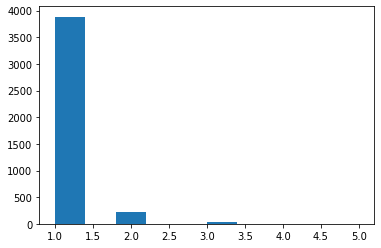

In [70]:
from matplotlib import pyplot as plt
plt.hist([len(s) for s in unique_id_sets])

So the vast majority of `customer_ids` are only correlated with themselves (as far as we can tell with our data). That's good. Note that we can't say for certain whether we're undercounting those associations or not with the data we have.

In [76]:
tuple(sorted(unique_id_sets, key=lambda s: -len(s)))[:5]

(frozenset({'477f0045-dcc4-43b7-b98a-22014055231e',
            '51103a46-f52a-4250-a806-ab95e73ad550',
            '6563418a-d7fb-4328-9062-e52ac0b607e2',
            'b8118b84-8059-42b8-a301-f14f43dea33c',
            'e403ead9-73ef-4fb6-ac5e-d42939270fb6'}),
 frozenset({'363554be-211a-4f40-9ee2-8ce87c30058b',
            '370fd05e-eda8-4bf4-bd07-00b5735d38bc',
            '969ea74a-3e03-431c-98bd-ff1b4c5a9f29',
            'cb35f24f-f3d4-433a-9c52-6e213aeca853'}),
 frozenset({'51103a46-f52a-4250-a806-ab95e73ad550',
            '6563418a-d7fb-4328-9062-e52ac0b607e2',
            'b8118b84-8059-42b8-a301-f14f43dea33c',
            'e403ead9-73ef-4fb6-ac5e-d42939270fb6'}),
 frozenset({'527ed39e-d91d-45f8-af23-fe44d79e7868',
            '669dd84b-22dd-4faa-a018-ac364e6a5fa6',
            'c287ccb0-e426-4b7c-87c2-8f83f74ef473',
            'e07c3c15-55cc-4f4f-a31a-0ee18f829c31'}),
 frozenset({'02915ec8-5fc9-4beb-83e4-1692dc25763d',
            '303010e6-60c2-4877-9609-6279893d6125',
    

## MVP

Given that so many of the `cutomer_id` values aren't grouped with any other IDs that we can identify, let's just go without grouping as a first pass. It will result in over-counting, but let's see how much over-counting there actually is.

Options:
1.  Just take the `customer_id` from one of the associated records (i.e., the micropayment, or one of the taps) -- ideally the one with the latest timestamp.
2.  Try to get the latest `pricipal_customer_id` off of the funding source and use that as canonical.

For option (1) the easiest thing to do would be to choose a consistent source (i.e., either the micropayment customer or the first-tap customer), likely the micropayment customer. An assumption that we could test is that the transaction time on the micropayment is never before the timestamp on associated transactions.

For option (2), it would still be helpful to just choose one of the `customer_id` values, but also we would need to make a couple more assumptions: that for the latest versions of `customer_id` records in `customer_funding_source`, there's only one corresponding `principal_customer_id`, and each of those principals is its own principal.

In [89]:
%%sql

-- Assumption: The transaction time on a micropayment will never be before the timestamp on an associated transaction.

select
    micropayment_id,
    cast(transaction_time as timestamp) as transaction_time,
    littlepay_transaction_id,
    cast(transaction_date_time_utc as timestamp) as transaction_date_time_utc
from payments.stg_cleaned_micropayments
join payments.stg_cleaned_micropayment_device_transactions using (micropayment_id)
join payments.stg_cleaned_device_transactions using (littlepay_transaction_id)
where cast(transaction_time as timestamp) < cast(transaction_date_time_utc as timestamp)

,micropayment_id,transaction_time,littlepay_transaction_id,transaction_date_time_utc


In [87]:
%%sql

-- Assumption: The lastest versions of records by customer_id only ever have one associated pricipal_customer_id

with

principal_customers as (
    select distinct customer_id, principal_customer_id
    from payments.stg_enriched_customer_funding_source
    where calitp_customer_id_rank = 1
),

counted_principal_customers as (
    select customer_id, principal_customer_id, count(*) over (partition by customer_id) as num_principals
    from principal_customers
)

select *
from counted_principal_customers
where num_principals > 1
order by customer_id

,customer_id,principal_customer_id,num_principals


In [88]:
%%sql

-- Assumption: Each pricipal_customer_id should only ever have itself as principal

with

principal_customer_ids as (
    select distinct principal_customer_id
    from payments.stg_enriched_customer_funding_source
    where calitp_customer_id_rank = 1
),

principal_funding_sources as (
    select customer_id, principal_customer_id
    from payments.stg_enriched_customer_funding_source
    where calitp_customer_id_rank = 1
        and customer_id in (select principal_customer_id from principal_customer_ids)
)

select *
from principal_funding_sources
where customer_id <> principal_customer_id

,customer_id,principal_customer_id


All of these assumptions appear to hold, so we should:

1. Add a staging model for `stg_cleaned_principal_customers` that associates `customer_id` with `principal_customer_id`.
2. Create the three validations above.
3. Join principal customer information into `payments_trips`.

Do we need to keep track of principal customer ids over time? I'm thinking no, because what we're tracking is not customers. If we have an ID associations table or something it would make sense to track changes over time, but for now we're just interested in associating common customers.

But what if we want to, for example, check payment media, and a customer's payment medium changed? A customer is the closest thing we have to a dimension in this dataset so far. Transactions, micropayments, adjustments -- these are all things that _happen_. A customer funding source is a thing that _is_.

So, let's try to construct the cleaned customer table as a simple distinct pair of customer_id, principal_customer_id, and the customer funding source table as a slowly changing dimension. I'm going to create these two tables separately because we can join with the `principal_customer` table using just the `customer_id` and that will be a complete join, but then we can still `left join` with the cleaned `customer_funding_source` table using the `customer_id` and the `funding_source_id` to ensure that we get the correct funding source record. There will be some `NULL` `customer_funding_source` matches, but that's ok -- at least those that _do_ match should be correct.

In [96]:
%%sql

-- stg_cleaned_principal_customer

SELECT DISTINCT
    customer_id,
    principal_customer_id,
FROM payments.stg_enriched_customer_funding_source
WHERE calitp_dupe_number = 1
    AND calitp_customer_id_rank = 1

,customer_id,principal_customer_id
0,a2fdec25-d582-407e-8a77-242b7e16f9fd,a2fdec25-d582-407e-8a77-242b7e16f9fd
1,9f0e6e8c-48e7-4df4-bb61-7033f971d38f,9f0e6e8c-48e7-4df4-bb61-7033f971d38f
2,4fb039b6-6621-46b5-9e05-e3341f711f9c,4fb039b6-6621-46b5-9e05-e3341f711f9c
3,92143cca-c7f4-4381-b5ea-f470b0ad3725,92143cca-c7f4-4381-b5ea-f470b0ad3725
4,0bfbf2bd-6162-47b6-a087-5375b32b510c,0bfbf2bd-6162-47b6-a087-5375b32b510c
...,...,...
4551,09c4ba04-40d8-4659-9caf-e342d3047157,09c4ba04-40d8-4659-9caf-e342d3047157
4552,9c51a87a-24e7-40fc-ac2b-1738d5d49397,9c51a87a-24e7-40fc-ac2b-1738d5d49397
4553,9b6a65f2-d0db-4385-a766-ddf1fdea0e2e,9b6a65f2-d0db-4385-a766-ddf1fdea0e2e
4554,07504c74-ef8a-4687-95c3-abe0a60c41e8,07504c74-ef8a-4687-95c3-abe0a60c41e8


In [93]:
%%sql

-- stg_cleaned_customer_funding_source

SELECT
    customer_id,
    funding_source_vault_id,
    principal_customer_id,
    bin,
    masked_pan,
    card_scheme,
    issuer,
    issuer_country,
    form_factor,
    calitp_export_datetime AS calitp_valid_at,
    COALESCE(LAG(calitp_export_datetime) OVER (
        PARTITION BY funding_source_vault_id, customer_id 
        ORDER BY calitp_customer_id_rank), DATETIME(TIMESTAMP '9999-12-31 23:59:59+00:00')) AS calitp_invalid_at
FROM payments.stg_enriched_customer_funding_source
WHERE calitp_dupe_number = 1
ORDER BY customer_id, calitp_valid_at desc

,customer_id,funding_source_vault_id,principal_customer_id,bin,masked_pan,card_scheme,issuer,issuer_country,form_factor,calitp_valid_at,calitp_invalid_at
0,00088438-f2e9-45ba-a707-4784e7016db9,213a6e12-3b4c-4cbe-874b-39e3d97c289a,00088438-f2e9-45ba-a707-4784e7016db9,449465,449465******7590,VISA,GOLDEN 1 C.U.,UNITED STATES,CARD,2021-11-10 05:04:00,9999-12-31 23:59:59
1,001a3538-cdf2-4f07-8369-76916132e154,607fcc56-be28-43ba-b65e-6c4493261ef5,001a3538-cdf2-4f07-8369-76916132e154,499001,499001******9210,VISA,NATIXIS,FRANCE,CARD,2021-10-15 08:06:00,9999-12-31 23:59:59
2,003db1c7-7f67-4008-9965-e67d3ae505b2,2cf01ee4-3b37-4f95-affe-8aa01c137247,003db1c7-7f67-4008-9965-e67d3ae505b2,536496,536496******7365,MASTERCARD,KBC BANKVERZEKERINGSHOLDING (KBC BANK N.V.),BELGIUM,CARD,2021-10-15 08:06:00,9999-12-31 23:59:59
3,003ee1c6-d387-4470-ae94-2d1c68c81bb3,3294448f-f083-4c09-9073-30604ac4be8e,003ee1c6-d387-4470-ae94-2d1c68c81bb3,434256,434256******5276,VISA,"WELLS FARGO BANK, N.A.",UNITED STATES,CARD,2021-10-15 08:05:00,9999-12-31 23:59:59
4,005c7cc3-2b28-4e0f-906a-ace10faad8cd,b91f6040-0328-4c03-a00c-12cdc2c1f547,005c7cc3-2b28-4e0f-906a-ace10faad8cd,481582,481582******0794,VISA,"BANK OF AMERICA, N.A.",UNITED STATES,CARD,2021-10-15 08:05:00,9999-12-31 23:59:59
...,...,...,...,...,...,...,...,...,...,...,...
4907,ffc0914e-58d1-4fea-8ece-6c8979955f4a,d7b0975a-d16d-4b17-b8b3-abaf750f4a9c,ffc0914e-58d1-4fea-8ece-6c8979955f4a,411398,411398******5223,VISA,"FIA CARD SERVICES, N.A.",UNITED STATES,None,2021-10-15 08:05:00,9999-12-31 23:59:59
4908,ffe21fbf-7b13-449d-b508-f506fb60cc11,59e43405-525f-4dcf-a479-06e9521f0106,ffe21fbf-7b13-449d-b508-f506fb60cc11,540812,540812******4347,MASTERCARD,BOEING EMPLOYEES CREDIT UNION,UNITED STATES,None,2021-10-15 08:06:00,9999-12-31 23:59:59
4909,ffe21fbf-7b13-449d-b508-f506fb60cc11,2364f203-2534-4142-bb27-2799bf26241c,ffe21fbf-7b13-449d-b508-f506fb60cc11,522660,522660******1793,MASTERCARD,SVENSKA HANDELSBANKEN AB,SWEDEN,CARD,2021-10-15 08:06:00,9999-12-31 23:59:59
4910,fff2c56c-5f04-4efb-82fd-18b9c8ac3c88,c497fceb-f4e6-4047-9683-9a3a139c083d,fff2c56c-5f04-4efb-82fd-18b9c8ac3c88,440393,440393******7853,VISA,"BAY FIRST BANK, N.A.",UNITED STATES,None,2021-10-18 23:15:00,9999-12-31 23:59:59


What's the difference in the number of customers if we use only customer ID vs replacing with principal customer ID?

In [90]:
%%sql

select count(distinct customer_id)
from payments.stg_cleaned_micropayments
join payments.stg_cleaned_micropayment_device_transactions using (micropayment_id)

,f0_
0,4104


In [91]:
%%sql

with

principal_customers as (
    select distinct customer_id, principal_customer_id
    from payments.stg_enriched_customer_funding_source
    where calitp_customer_id_rank = 1
)

select count(distinct principal_customer_id)
from payments.stg_cleaned_micropayments
join payments.stg_cleaned_micropayment_device_transactions using (micropayment_id)
join principal_customers using (customer_id)

,f0_
0,4060


That's just over 40 IDs -- 1% of the total distinct IDs. Not many.